In [7]:
from sklearn.datasets import fetch_20newsgroups
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Load dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data


In [10]:
# Preprocessing function
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS

In [12]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

documents_clean = [preprocess(doc) for doc in documents]

In [13]:
#Feature Extraction (TF-IDF and BOW)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(documents_clean)

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer_tfidf.fit_transform(documents_clean)

In [14]:
# Clustering (KMeans + Hierarchical)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans.fit(X_tfidf)
labels = kmeans.labels_

In [15]:
# Evaluate
sil_score = silhouette_score(X_tfidf, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: -0.003


In [16]:
# Top terms per cluster
import numpy as np

def top_terms_per_cluster(tfidf, labels, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    for i in range(np.max(labels)+1):
        centroid = kmeans.cluster_centers_[i]
        top_terms_idx = centroid.argsort()[::-1][:n_terms]
        top_terms = [terms[ind] for ind in top_terms_idx]
        print(f"Cluster {i}: {', '.join(top_terms)}")

top_terms_per_cluster(X_tfidf, labels, vectorizer_tfidf)

Cluster 0: blessed, filled, feels, fees, feet, fell, fellow, felt, female, fewer
Cluster 1: just, like, good, dont, think, new, know, time, game, im
Cluster 2: tiff, gif, file, formats, image, spec, files, format, convert, bmp
Cluster 3: bike, ride, dod, bikes, riding, just, like, im, motorcycle, miles
Cluster 4: people, god, dont, think, just, like, say, know, believe, government
Cluster 5: computer, measure, stand, voice, sensor, offering, neutral, involves, victims, arm
Cluster 6: thanks, windows, email, know, does, file, use, card, im, program
Cluster 7: subscribe, mailing, list, quit, honda, located, israel, david, want, feelings
Cluster 8: joke, sigh, april, thought, post, article, david, fool, stop, reading
Cluster 9: drive, scsi, drives, disk, mb, hard, ide, controller, floppy, meg
Cluster 10: teach, parents, children, responsible, dc, sins, fail, properly, held, thou
Cluster 11: bull, blood, reserved, species, preferably, animal, choose, religion, process, christian
Cluster 12

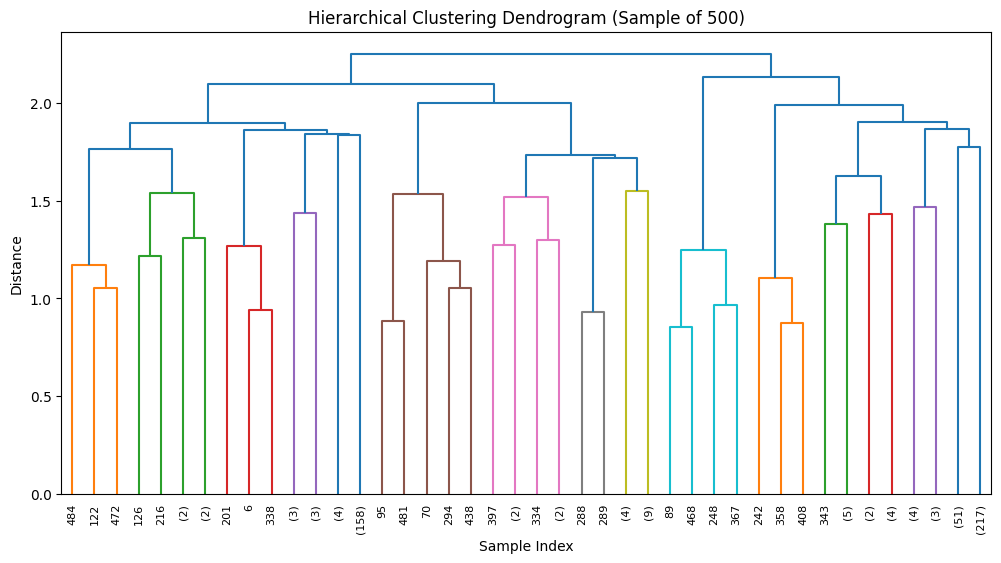

In [17]:
# Hierarchical Clustering (sampled for dendrogram)
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X_tfidf[:500].toarray(), method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Sample of 500)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

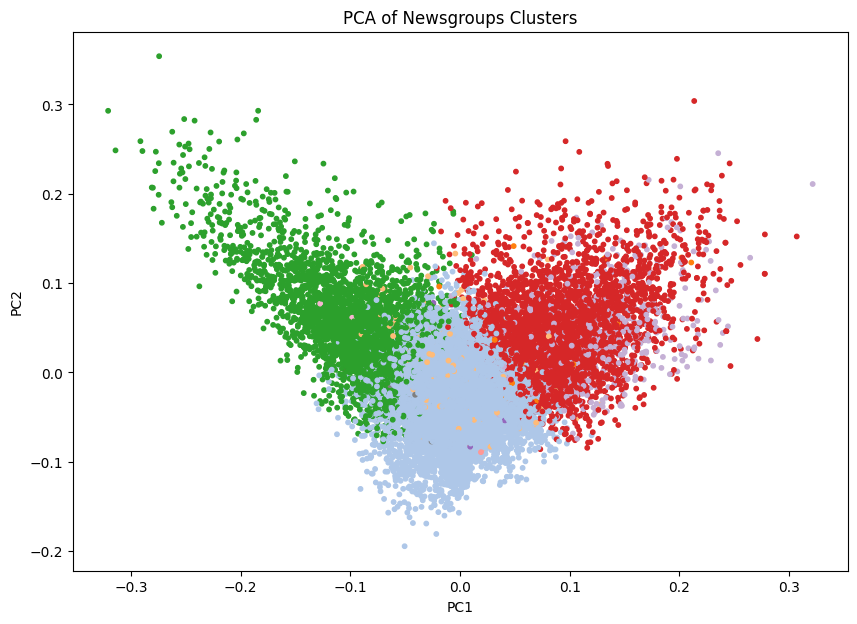

In [19]:
 #PCA Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab20', s=10)
plt.title("PCA of Newsgroups Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [20]:
# Predict cluster of new documents

new_docs = [
    "The spacecraft successfully entered Mars orbit yesterday.",
    "My new graphics card makes gaming so smooth."
]

new_docs_clean = [preprocess(doc) for doc in new_docs]
X_new = vectorizer_tfidf.transform(new_docs_clean)
predictions = kmeans.predict(X_new)

for doc, cluster in zip(new_docs, predictions):
    print(f"'{doc[:50]}...' => Cluster {cluster}")

'The spacecraft successfully entered Mars orbit yes...' => Cluster 1
'My new graphics card makes gaming so smooth....' => Cluster 6


# Text Clustering on 20 Newsgroups Dataset

Objective:
Apply unsupervised learning techniques (KMeans, Hierarchical Clustering) to discover latent topics in the 20 Newsgroups dataset.


Data Preparation:

I converted all text to lowercase to ensure consistency. I removed punctuation and non-alphabetic characters using regular expressions. I tokenized the text by splitting it into words. After tokenization, I removed common English stopwords to reduce noise and focus on meaningful terms. The cleaned text was then rejoined into processed documents, ready for feature extraction.

Clustering Results Summary

I applied hierarchical clustering to a sample of 500 documents from the Newsgroups dataset. The dendrogram illustrates how these documents group together at different levels of similarity. Each merge in the dendrogram represents a cluster being formed by joining smaller clusters. The greater the height of the merge, the more dissimilar the joined clusters are.

Visualization

I also used PCA (Principal Component Analysis) to reduce the high-dimensional TF-IDF feature space to two dimensions for visualization. The PCA scatter plot shows how documents are distributed across clusters. Although some separation between major clusters is visible, there is significant overlap, indicating that the clusters are not well-defined in this reduced space.

The silhouette score of -0.003 indicates very poor cluster quality. A silhouette score near zero or negative suggests that documents may have been assigned to incorrect clusters or that the clustering does not capture meaningful groupings in the data. This result reflects the challenges of clustering complex, high-dimensional text data without supervision.

